In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Importando o dataset e realizando uma visualização geral/superficial inicial

In [30]:
winequality_dataset = pd.read_csv("winequality.csv")
winequality_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            6497 non-null   int64  
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
 13  wine_is_red           6497 non-null   int64  
dtypes: float64(11), int64(3)
memory usage: 710.7 KB


Realizando uma análise um pouco mais detalhada a cerca de como os dados e como eles estão distribuidos

In [31]:
winequality_dataset.describe()

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_is_red
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,3248.000000,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114
std,1875.666681,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,1624.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000
50%,3248.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000
75%,4872.000000,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000
max,6496.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


Limpeza do dataset

In [32]:
#Remove a coluna chamada "Unnamed: 0".
winequality_dataset.drop('Unnamed: 0', axis=1, inplace=True)
#Substituindo os espaços entre as palavras do cabeçalho pelo underline.
winequality_dataset.columns = winequality_dataset.columns.str.replace(" ", "_")

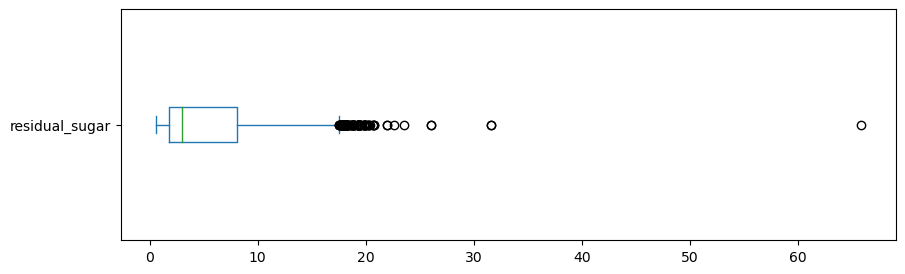

In [33]:
#Plotagem de um gráfico simples para analisar melhor a coluna residual_sugar.
winequality_dataset.residual_sugar.plot(kind='box', vert=False, figsize=(10,3))
#Remove os casos que possuem valores maiores que 25 (só há três valores maiores)
winequality_dataset.drop(winequality_dataset[winequality_dataset.residual_sugar > 25].index, axis=0, inplace=True)

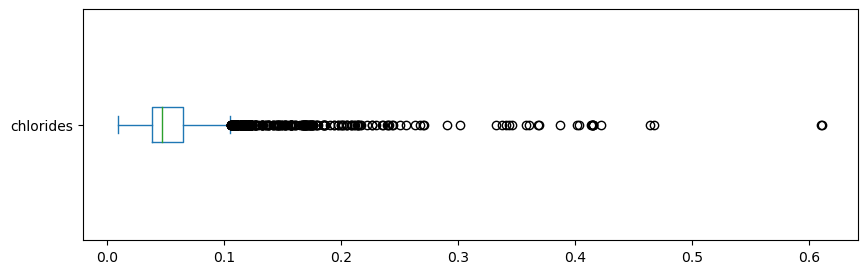

In [34]:
#Plotagem de um gráfico simples para analisar melhor a coluna chlorides.
winequality_dataset.chlorides.plot(kind='box', vert=False, figsize=(10,3))
#Remove os casos que possuem valores maiores que 25 (só há três valores maiores)
winequality_dataset.drop(winequality_dataset[winequality_dataset.chlorides > 0.3].index, axis=0, inplace=True)

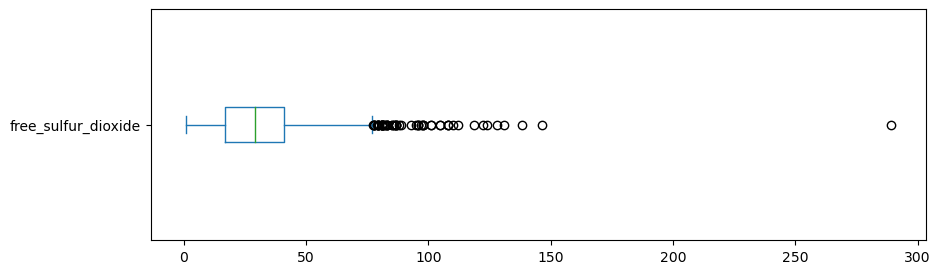

In [35]:
#Plotagem de um gráfico simples para analisar melhor a coluna free sulfur dioxide.
winequality_dataset.free_sulfur_dioxide.plot(kind='box', vert=False, figsize=(10,3))
#Remove os casos que possuem valores maiores que 150 (há apenas um)
winequality_dataset.drop(winequality_dataset[winequality_dataset.free_sulfur_dioxide > 120].index, axis=0, inplace=True)

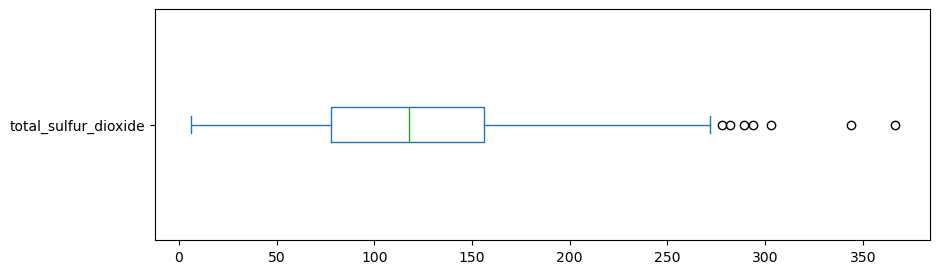

In [36]:
#Plotagem de um gráfico simples para analisar melhor a coluna total sulfur dioxide.
winequality_dataset.total_sulfur_dioxide.plot(kind='box', vert=False, figsize=(10,3))
#Remove os casos que possuem valores maiores que 250 (há apenas um)
winequality_dataset.drop(winequality_dataset[winequality_dataset.total_sulfur_dioxide > 275].index, axis=0, inplace=True)

Separando o dataset entre dataset de treinamento e de teste

In [37]:
x = winequality_dataset.iloc[:, 0:11]
qualidade = winequality_dataset.iloc[:, 11]
y = winequality_dataset.iloc[:, 12]

x_treinamento, x_teste, y_treinamento, y_teste, qual_treinamento, qual_teste = train_test_split(x, y, qualidade, random_state=0, test_size=0.2)

In [38]:
#Normalizando o dataset
normaliza = StandardScaler()

x_treinamento = normaliza.fit_transform(x_treinamento)
x_teste = normaliza.transform(x_teste)

Aplicando o algoritmo de KNN

In [39]:
#Verificando o valor de K ideal
import math
math.sqrt(len(x_treinamento))
#Como 72 é um número par, vamos utilizar o valor de 71

71.85401867675878

In [40]:
from collections import Counter

#Euclidean Distance
def calcula_distancia(ponto1, ponto2):
    distancia = np.sqrt(np.sum((ponto1-ponto2)**2))
    return distancia
 
#Function to calculate KNN
def predict(x_train, y_train , x_test, y_test, k):
    rotulos_y_test = []
    #Loop atraves dos pontos que precisam ser classificados
    for ponto_teste in x_test: 
        #Lista para armazenar as distancias
        point_dist = []
        #Loop atravesando cada dado do treinado
        for ponto_treino in range(len(x_train)): 
            #Calcula distancia
            distances = calcula_distancia(np.array(x_train[ponto_treino,:]), ponto_teste) 
            #Armazena as distancias na lista
            point_dist.append(distances) 

        dataframe_distancias = pd.DataFrame(data=point_dist, columns=['dist'], index=y_train.index)

        #Ordena as distancias e considera apenas as K pontos mais próximos 
        dataframe_ordenado = dataframe_distancias.sort_values(by=['dist'], axis=0)[:k]
         
        #Rastreia qual o rótulo dos K objetos mais próximos
        counter = Counter(y_train[dataframe_ordenado.index])
         
        # Get most common label of all the nearest neighbors
        prediction = counter.most_common()[0][0]
        rotulos_y_test.append(prediction)
        
    return rotulos_y_test

In [41]:
y_pred = predict(x_treinamento, y_treinamento, x_teste, y_teste, 71)

In [42]:
#Realizando o teste de acurácia
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(accuracy_score(y_teste, y_pred))

0.9938032532920217


In [43]:
#Comparar o resultado obtido com o resultado gerado pelo algoritmo de KNN fornecido pelo sklearn
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=71)
clf.fit(x_treinamento, y_treinamento)
y_pred_test = clf.predict(x_teste)

print(f"Sklearn KNN Accuracy: {accuracy_score(y_teste, y_pred_test)}")

Sklearn KNN Accuracy: 0.9938032532920217


Classificação multiclasse da qualidade do vinho com o algoritmo de Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#Separa o dataset em treinamento e teste (tendo como "resposta" as qualidades)
x = winequality_dataset.iloc[:, 0:11]
y = winequality_dataset.iloc[:, 11]

x_treinamento, x_teste, y_treinamento, y_teste = train_test_split(x, y, random_state=0, test_size=0.2)

In [ ]:
#Normalizando os dados
x_treinamento = normaliza.fit_transform(x_treinamento)
x_teste = normaliza.transform(x_teste)

In [ ]:
#Define função
random_forest = RandomForestClassifier()

#Define os possíveis parametros que serão testados, até se encontrar o melhor
parametros = {
    'n_estimators': np.arange(50, 200, 10),
    'max_depth': [None] + list(np.arange(10, 50, 5)),
    "criterion": ['entropy', 'gini'],
    "max_features": ['sqrt', 'log2'],
    "bootstrap": [False, True],
    "max_depth": [10, 15, 20],
    'min_samples_leaf': np.arange(1, 5),
    'min_samples_split': np.arange(2, 11),
}

In [ ]:
#Realiza 20 interações aleatórias entre os parametros
busca_aleatoria = RandomizedSearchCV(estimator=random_forest, param_distributions=parametros, n_iter=20, cv=5)
busca_aleatoria.fit(x_treinamento, y_treinamento)

#Printa o melhor conjunto de parametros encontrados
print(busca_aleatoria.best_params_)

In [ ]:
#Realiza o treinamento
random_forest = RandomForestClassifier(n_estimators= 130, min_samples_split= 2, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 20, criterion= 'gini', bootstrap= True)
random_forest.fit(x_treinamento, y_treinamento)

#Realiza o teste
y_pred=random_forest.predict(x_teste)
print(accuracy_score(y_teste,y_pred))